<a href="https://colab.research.google.com/github/Kata5/DeepLearning2021/blob/main/DeepLearning2021Milestone03.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab"/></a>

PLease find the detailed discussion of variational autoencoders in the attached documentation

Download the CelebA dataset

In [1]:
!gdown --id 1uy2L1qT4kR8QWh6W0TEBqPuezMvJChgW

Downloading...
From: https://drive.google.com/uc?id=1uy2L1qT4kR8QWh6W0TEBqPuezMvJChgW
To: /content/img_align_celeba.zip
100% 1.44G/1.44G [00:12<00:00, 117MB/s]


In [2]:
!unzip -q img_align_celeba.zip -d data

replace data/img_align_celeba/000001.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: All


In [3]:
!gdown --id 1nDQffbFImz9mmuRdBIm9_3adOQBZ8rY3

Downloading...
From: https://drive.google.com/uc?id=1nDQffbFImz9mmuRdBIm9_3adOQBZ8rY3
To: /content/list_attr_celeba.csv
100% 24.9M/24.9M [00:00<00:00, 117MB/s] 


In [4]:
import torch
torch.manual_seed(5)

In [5]:
import random
random.seed(5)

After have some pilot projects with Tensorflow,Keras and PyTorch I decided to use the later one as it is much simpler to implement Variational Autoencoder with it.
GPU optimalisation is essentiala check is done for availability

In [6]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

import torch.optim as  optim 
if torch.cuda.is_available():  
  dev = "cuda:0" 
  print("gpu up")
else:  
  dev = "cpu"  
device = torch.device(dev)

gpu up


Reading the csv for attributes

In [7]:
df = pd.read_csv("list_attr_celeba.csv", delimiter = ';')

In [8]:
def haircolor(x):
    if x["Blond_Hair"] == 1:
        return 0
    elif x["Brown_Hair"] == 1:
        return 1
    elif x["Black_Hair"] == 1:
        return 2
    else :
        return 3
    
df["Hair_Color"] = df.apply(haircolor,axis=1)

In [9]:
"""
for simplicity I decided to make the VAE capture just for attributes 

Hair Color (blond,brown,black and neither of these(or unknown))
Pale Skin 
Gender 
Beard (in case of male)
"""

df = df[["image_id","Hair_Color",'Pale_Skin',"Male","No_Beard"]]

In [10]:
"""
replacing -1 with 0 without affecting the the 1 values 

"""
df.Pale_Skin = df.Pale_Skin.apply(lambda x: max(x,0)) 
df.Male = df.Male.apply(lambda x: max(x,0))
df.No_Beard = df.No_Beard.apply(lambda x: max(x,0))


In [11]:
df

image_id  Hair_Color  Pale_Skin  Male  No_Beard
0       000001.jpg           1          0     0         1
1       000002.jpg           1          0     0         1
2       000003.jpg           3          0     1         1
3       000004.jpg           3          0     0         1
4       000005.jpg           3          0     0         1
...            ...         ...        ...   ...       ...
202594  202595.jpg           0          0     0         1
202595  202596.jpg           0          1     1         1
202596  202597.jpg           2          0     1         1
202597  202598.jpg           2          0     0         1
202598  202599.jpg           0          1     0         1

[202599 rows x 5 columns]

In [12]:
def ceil(a,b):
    return -(-a//b)

In [13]:
faces =[]
for i in df.iloc[:20000].image_id:
    pic = Image.open("data/img_align_celeba/"+i)
    pic = pic.resize((64,64))
    pix = np.array(pic.getdata()).reshape(pic.size[0], pic.size[1], 3)
    pix = pix/255
    """
    for the images I had to use np.moveaxis to change the shape from  (64,64,3) to (3,64,64)
    without messing up the image 
    
    """
    faces.append(np.moveaxis(pix,-1,0).tolist())
    
faces = np.array(faces)

Some ideas for implementing AutoEncoders in PyTorch were used from this page and (links opening from here):
https://discuss.pytorch.org/t/autoencoders-in-pytorch/844

In [14]:
class Encoder(nn.Module):
    def __init__(self, k):
        
        super(Encoder,self).__init__()
        # parameters from https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html 
        # channels_in, channels_out, kernel_size, stride , padding,
        self.conv1 = nn.Conv2d(3,k*32,3,1,1)
        self.maxp1 = nn.MaxPool2d(kernel_size=2,stride=2)
        
        self.conv2 = nn.Conv2d(k*32,k*32,3,1,1)
        self.maxp2 = nn.MaxPool2d(kernel_size=2,stride=2)
        
        self.conv3 = nn.Conv2d(k*32,k*32,4,2,1)
        self.maxp3 = nn.MaxPool2d(kernel_size=2,stride=2)
        
        self.conv4 = nn.Conv2d(k*32,128,4,2,1)
        self.maxp4 = nn.MaxPool2d(kernel_size=2,stride=2)


    # forward fuction for Encoder    
    def forward(self,x):
        out = self.conv1(x)
        out = self.maxp1(out)
        out = F.relu(out) 
        
        out = self.conv2(out)
        out = self.maxp2(out)
        out = F.relu(out)
        
        out = self.conv3(out)
        out = self.maxp3(out)
        out = F.relu(out)
        
        out= self.conv4(out)
        out = self.maxp4(out)
        out = F.relu(out)
        
        return out.view(out.shape[0],-1)
    
class Decoder(nn.Module):
    def __init__(self, k):
        super(Decoder,self).__init__()
        
        """
        ConvTranspose2d is very similar to the convolution operation but the convolution matrix is transposed, 
        so the result is that the output grows instead of reducing(depending on the padding, stride and kernel size used). 
        Parameters are:
        # in_channels, out_channels, kernel_size, stride=1, padding=0, output_padding=0
        """
        self.transconv1 = nn.ConvTranspose2d(64+ 40,32*k,8,4,2)
        self.transconv2 = nn.ConvTranspose2d(32*k,32*k,8,4,2)
        self.transconv3 = nn.ConvTranspose2d(32*k,32*k,4,2,1)
        self.transconv4 = nn.ConvTranspose2d(32*k,3,4,2,1)
        
        """
        Embedding layers were used which are a simple lookup tables that stores embeddings of a fixed dictionary and size.
        Some features were converted into a vector to get a conditional VAE
        I.e. Hair 'states' were converted into a vector of 10 weights
        
        """
        self.hairEmbedding = nn.Embedding(4,10)
        self.beardEmbedding = nn.Embedding(2,10)
        self.genderEmbedding = nn.Embedding(2,10)
        self.paleSkinEmbedding = nn.Embedding(2,10)

        
    def forward(self,x):
        """
        Here z are sampled from x (encoded image)
        and then feature vectors are concatenating to z
        """
        z = x[:,:64]
        hair = self.hairEmbedding(x[:,64].long())
        paleSkin = self.paleSkinEmbedding(x[:,65].long())
        gender = self.genderEmbedding(x[:,66].long())
        beard = self.beardEmbedding(x[:,67].long())
        
        z = torch.cat([z,hair,beard,gender,paleSkin],dim=1)
        
        # ConvTranspose2d layers were used to the increasing the dimension of the output
        
        out= self.transconv1(z.view(z.shape[0],z.shape[1],1,1))
        out = F.relu(out)
        
        out= self.transconv2(out)
        out = F.relu(out)

        out= self.transconv3(out)
        out = F.relu(out)

        out= self.transconv4(out)
        out = F.relu(out)

        return out
        
class CVAE(nn.Module):
    def __init__(self,encoder,decoder,k):
        # Here I used super fuction, which returns a proxy object that delegates method calls to a parent class (ie.: nn.Module right now) of type.
        # This is useful for accessing inherited methods that have been overridden in a class. 
        super(CVAE,self).__init__() # 
        self.encoder = encoder(k)
        self.decoder = decoder(k)
        
    def forward(self,x,attrs):
        h = self.encoder(x)
        
        mu = h[:,:64]
        logvar = h[:,64:]
        '''
        Here we use a well-known reparameterization trickof VAEs
        for more details please have a look at my assignment documentation 
        (based on https://towardsdatascience.com/reparameterization-trick-126062cfd3c3)
        '''
        s= torch.exp(logvar)
        eps = torch.randn_like(s)
        z = s*eps + mu 
        
        z= torch.cat([z,attrs],dim=1)
        out = self.decoder(z)
        return out,mu,logvar
        


In [15]:
for k in [2,4]:
    vae = CVAE(Encoder,Decoder,k)
    vae.to(device)
    """
    Now, the loss function is implemented with reconstruction loss and 
    the difference between the distribtions (measured with the classic metric for it: Kullback-Leibler divergence.
    https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence
    """

    def loss_function(recon_x,x,mu,logvar):
        KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        KLD /= x.shape[0] * 3 * 64 * 64
        recon_loss = F.mse_loss(recon_x,x)
        return recon_loss +  KLD

    epochs = 2 # HERE I SET IT TO 5 SO THAT TO BE ABLE TO RUN IT. 
    # ONE CAN FIND THE VAE_K_B.pt FILES IN THE RESULT FOLDER. THE BEST VAE.PT IS USED FOR VISUALIZATION
    early_stopping_window = 10
    
    for b in [1,2,4]:
        batch_size= 16*b
        # https://pytorch.org/docs/stable/generated/torch.optim.Adagrad.html
        # Adaptive Subgradient Methods for Online Learning and Stochastic Optimization
        optimizer = optim.Adagrad(vae.parameters(),lr = 0.001)

        npData = df.iloc[:20000].to_numpy()

        n_samples = len(npData)

        better_batch_size = ceil(n_samples, ceil(n_samples, batch_size))
        losstrack = []
        for e in range(epochs):
            losses = []
            for i in range(ceil(n_samples, better_batch_size)):
                batch = npData[i * better_batch_size: (i+1) * better_batch_size]
                attrs = torch.Tensor(batch[:,1:].astype('float16')).to(device)
        #         break
                imgs = faces[i * better_batch_size: (i+1) * better_batch_size]
                imgs = torch.Tensor(imgs.astype('float16')).to(device)
                vae.zero_grad()
                recon_imgs,mu,logvar = vae(imgs,attrs)
                err = loss_function(recon_imgs,imgs,mu,logvar)
                err.backward()
                optimizer.step()
                losses.append(err.item())
            losstrack.append(np.mean(losses))
            if e % 2 == 0: 
                torch.save(vae.state_dict(), f"./vae_k_{k}b_{b}.pt")
                print(np.mean(losses), "mean loss", e)
            if len(losstrack) > early_stopping_window and np.mean(losstrack[-early_stopping_window-1:-1]) < losstrack[-1]:
                print("Losses are no longer decreasing. Stopping.")
                break


0.07137957950234414 mean loss 0
0.05982794241905212 mean loss 0
0.06104679150988881 mean loss 0
0.05289214007109404 mean loss 0
0.040502176094055174 mean loss 0
0.04040480309877152 mean loss 0


In [16]:
vae = CVAE(Encoder,Decoder,2)
vae.to(device)

CVAE(
  (encoder): Encoder(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (maxp1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (maxp2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv3): Conv2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (maxp3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv4): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (maxp4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (decoder): Decoder(
    (transconv1): ConvTranspose2d(104, 64, kernel_size=(8, 8), stride=(4, 4), padding=(2, 2))
    (transconv2): ConvTranspose2d(64, 64, kernel_size=(8, 8), stride=(4, 4), padding=(2, 2))
    (transconv3): ConvTranspose2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1)

In [17]:
!gdown --id 1dnRy8oSZwtYQ0KHAPEEkTMO5qp5xEsuT

Downloading...
From: https://drive.google.com/uc?id=1dnRy8oSZwtYQ0KHAPEEkTMO5qp5xEsuT
To: /content/vae_best.pt
100% 3.98M/3.98M [00:00<00:00, 130MB/s]


In [18]:
"""The model I saved while training (vae.pt) is loaded"""

checkpoint = torch.load("vae_best.pt")
vae.load_state_dict(checkpoint)

<All keys matched successfully>

In [19]:
attrs = torch.Tensor(batch[:,1:].astype('float16')).to(device)
#         break
i=1
imgs = faces[i * 16: (i+1) * 16]
imgs = torch.Tensor(imgs.astype('float16')).to(device)
z = vae.encoder(imgs)


In [20]:

z_cpu = z.cpu().detach().numpy()

In [21]:
z_cpu.shape

(16, 128)

In [22]:
faces.shape

(20000, 3, 64, 64)



*   2nd dimension seems to code the rotation of the face
*   9th dimension seems to code the thickness of hair
*   12th dimension seems to code being fat :)
*   16th dimension seems to code color of the hair
*   26.th dimension seems to code the existence of bangs
*   27.th dimension seems to code the existence of bangs
*   28.th dimension seems to code the rotation of the face
*   29.th dimension seems to code the existence of sunglasses
*   61.th dimension seems to code the make-up


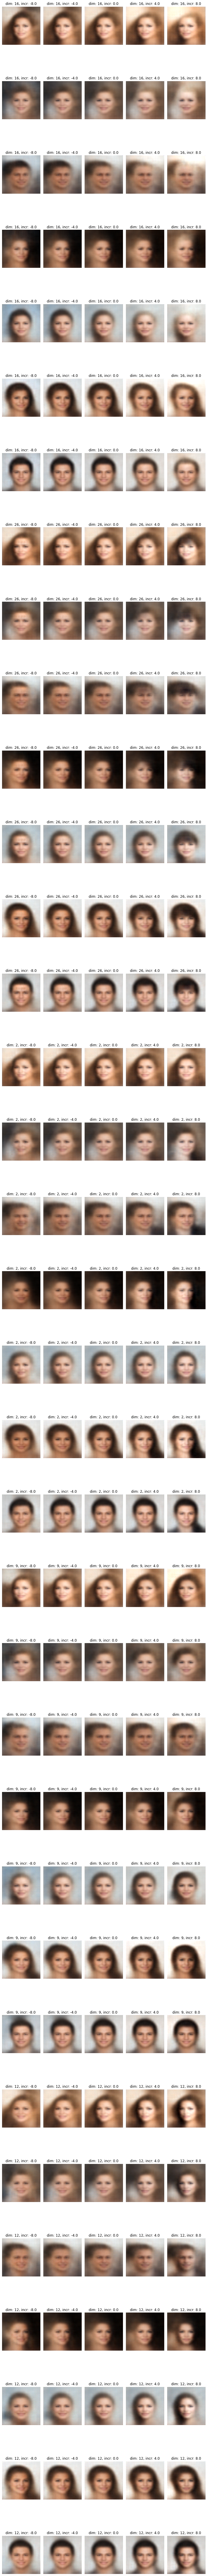

In [23]:
imnums = np.array([23,  7015, 33, 634, 10015, 2015, 25])
relevant_dims = [16,26, 2,9,12]# np. arange(28); #np.array([23, 27, 28, 61,  29 ]);
max_incr = 8.0
n_incrs = 5
f2, axarr2 = plt.subplots(len(relevant_dims)*len(imnums), n_incrs, figsize=(int(2.1*n_incrs), 2*64))

for idim, dim in enumerate(relevant_dims):
  for imnumi in range(len(imnums)):
    img = torch.Tensor(faces[imnumi:imnumi+1].astype('float16')).to(device)
    z0 = vae.encoder(img).cpu().detach().numpy()[0,:64]

    for iincr, incr in enumerate(np.linspace(-max_incr, max_incr, n_incrs)):
      increment = np.zeros((64,))
      increment[dim] = incr
      mu = torch.Tensor((z0 + increment).reshape(1, -1).astype('float16'))
      attrs = torch.Tensor(df.iloc[imnumi, 1:].to_numpy().reshape(1, -1).astype('float16'))
      h = torch.cat((mu, attrs), axis=1)
      img_mod = vae.decoder(h.to(device)).cpu().detach().numpy()
      img_mod = np.squeeze(np.moveaxis(img_mod, 1, -1)).clip(0.0, 1.0)
      axarr2[idim*len(imnums)+imnumi, iincr].imshow(img_mod, aspect=1) #'auto')
      axarr2[idim*len(imnums)+imnumi, iincr].set_title(f'dim: {dim}, incr: {incr}')
      axarr2[idim*len(imnums)+imnumi, iincr].axis('off')
      f2.tight_layout()

Here we compare the origival and the reconstructed images

[1 0 0 1]
[1 0 0 1]
[3 0 1 1]
[3 0 0 1]


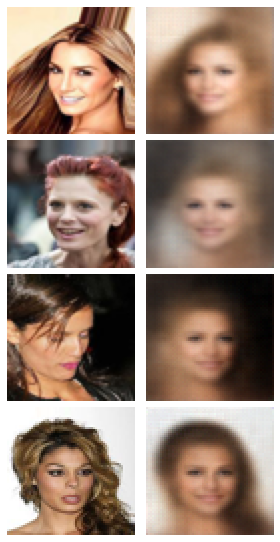

In [35]:
imnums = [0, 1,3,5]
f2, axarr2 = plt.subplots(len(imnums), 2, figsize=(2*2, 2*len(imnums)))

for imnumi, imnum in enumerate(imnums):
  img = faces[imnum:imnum+1]

  # column 0: original image
  img_disp = np.squeeze(np.moveaxis(img, 1, -1)).clip(0.0, 1.0)
  axarr2[imnumi, 0].imshow(img_disp, aspect=1)
  axarr2[imnumi, 0].axis('off')

  img = torch.Tensor(img.astype('float16')).to(device)
  z = vae.encoder(img).cpu()
  attrs0 = df.iloc[imnumi, 1:].to_numpy()
  print(attrs0)

  # column 1: reconstruction with ground truth attributes
  attrs = torch.Tensor(attrs0.astype('float16').reshape(1,-1))
  h = torch.cat((z, attrs), axis=1)
  img_mod = vae.decoder(h.to(device)).cpu().detach().numpy()
  img_mod = np.squeeze(np.moveaxis(img_mod, 1, -1)).clip(0.0, 1.0)
  axarr2[imnumi, 1].imshow(img_mod, aspect=1)
  axarr2[imnumi, 1].axis('off')

  f2.tight_layout()